# Q1. Computationally Efficient Eigenfaces

## Import libraries and data preprocessing

In [4]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import time
import random as rand

mat_file_name = "face.mat"

mat_content = sio.loadmat(mat_file_name)


face_data = mat_content['X']

#print(face_data) # Each column represents one face image, each row a pixel value for a particular coordinate of the image
#print(face_data.shape)

face_label = mat_content['l']

#print(face_label)
#print(face_label.shape)


In [5]:
'''Split data into 8:2'''
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(face_data.T, face_label.T, test_size=0.2, random_state=42, stratify=face_label.T )#random seed for reproducible split
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

'''compute the average face vector'''
avg_face_numpy = np.mean(X_train, axis = 0)
#plt.imshow(np.reshape(avg_face_numpy,(46,56)).T, cmap = 'gist_gray')


## Comparing eigenspaces


In [6]:
avg_face_numpy = np.mean(X_train, axis = 0)


A = np.transpose(X_train - avg_face_numpy)

M=200

S = (A @ A.T) # Default PCA
eval, evec = np.linalg.eig(S) # u
M_Largest_sorted_index_array = np.argsort(eval)[-M:]
M_eval = eval[M_Largest_sorted_index_array]
u = (evec.T)[M_Largest_sorted_index_array].T

low_S = (A.T @ A) # Low-D PCA
low_eval, low_evec = np.linalg.eig(low_S) # v
M_Largest_sorted_index_array = np.argsort(low_eval)[-M:]
M_low_eval = low_eval[M_Largest_sorted_index_array]
Av = (low_evec.T)[M_Largest_sorted_index_array].T
Av = (A@Av)
Av = Av / np.linalg.norm(Av,axis=0) 

### Number of zero eigenvalues

In [7]:
print("# of zero eigenvalues in default PCA: ",
      eval.shape[0] - np.nonzero(eval)[0].shape[0])

print("# of zero eigenvalues in lower-dimension PCA: ",
      low_eval.shape[0] - np.nonzero(low_eval)[0].shape[0])

# of zero eigenvalues in default PCA:  0
# of zero eigenvalues in lower-dimension PCA:  0


### Parallelity of eigenvectors

In [8]:
# inner product of two unit vectors are 1 if parallel ==> u//Av
out = []
for i in range(M):
    out.append(abs(np.dot(Av[:,i],u))) 
out=np.array(out)

parallelity = np.mean(np.linalg.norm(out * np.eye(M),axis=0))
print( "Parallelity of eigenvector : %s"%parallelity) # same eigen vectors!

Parallelity of eigenvector : 1.0


### Similarity of eigenvalues

In [9]:
mean = (M_low_eval + M_eval)/2
diff_rate = np.mean(np.abs((mean-abs(M_low_eval-M_eval.T))/mean)) * 100 # same eigen
print("Similarity of eigenvalue : %s %%"%diff_rate)


Similarity of eigenvalue : 99.99999999999964 %


## PCA model

### Effect of number of bases

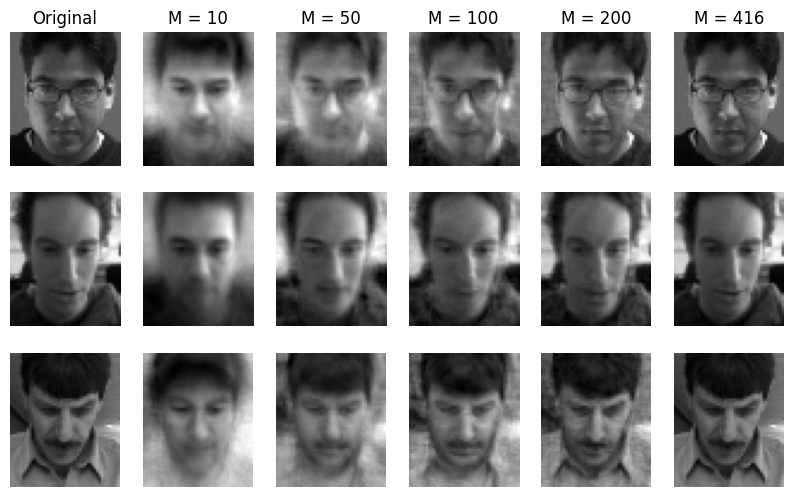

In [10]:
avg_face_numpy = np.mean(X_train, axis = 0)


A = np.transpose(X_train - avg_face_numpy)

low_S = (A.T @ A)

low_eval, low_evec = np.linalg.eig(low_S)
low_evec = np.transpose(low_evec)


X_tide = {}
low_X_tide = {}

avg_reconstruction = {}
low_avg_reconstruction = {}

M_list = [10, 50, 100, 200, 416]

for M in M_list:
    #low dimensional computation
    #find M largest eigenvectors
    M_Largest_sorted_index_array = np.argsort(low_eval)[-M:]
    low_U = low_evec[M_Largest_sorted_index_array].T
    W = A @ low_U
    
    # reconstruction using eigenfaces
    low_X_tide[M]  = avg_face_numpy + (W@low_U.T).T
    low_avg_reconstruction[M] = np.mean(low_X_tide[M], axis = 0)  

### plot for 3 train images and average image
i_num=3
plt.figure(figsize=(10,8))
for idx in range(i_num):
    rand_idx = rand.randint(0,X_test.shape[0]-1)
    plt.subplot(i_num+1,  len(M_list)+1,    idx*6+1)
    if idx == 0: 
        plt.title("Original")
    plt.axis(False)
    plt.imshow(np.reshape(X_train[rand_idx],(46,56)).T, cmap = 'gist_gray')
    for jdx in range(len(M_list)):
        plt.subplot(i_num+1,    len(M_list)+1,  idx*6+jdx+2)
        if idx == 0: 
            plt.title("M = %s"%M_list[jdx])
        plt.axis(False)
        plt.imshow(np.reshape(np.real(low_X_tide[M_list[jdx]][rand_idx]),(46,56)).T, cmap = 'gist_gray')
        
plt.show()

### Performance by methods

#### Time consumption of Default PCA

In [11]:
%%timeit

avg_face_numpy = np.mean(X_train, axis = 0)
A = np.transpose(X_train - avg_face_numpy)
S = (A @ A.T)

eval, evec = np.linalg.eig(S)
evec = np.transpose(evec)

M = 200

#find M largest eigenvectors
M_Largest_sorted_index_array = np.argsort(eval)[-M:]
U = np.real(evec[M_Largest_sorted_index_array].T)
W = np.real(A.T @ U)

# reconstruction using eigenfaces
X_tide = avg_face_numpy + W@U.T 

5.7 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Time consumption of Lower-Dimension PCA

In [12]:
%%timeit

avg_face_numpy = np.mean(X_train, axis = 0)
A = np.transpose(X_train - avg_face_numpy)
S = (A.T @ A)

eval, evec = np.linalg.eig(S)
evec = np.transpose(evec)

M = 200

#find M largest eigenvectors
M_Largest_sorted_index_array = np.argsort(eval)[-M:]
U = evec[M_Largest_sorted_index_array].T
W = A @ U

# reconstruction using eigenfaces
X_tide = avg_face_numpy + (W@U.T).T

121 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Single Image Classification

In [13]:
# classification of random input image
avg_face_numpy = np.mean(X_train, axis = 0)
A = np.transpose(X_train - avg_face_numpy)
S = (A.T @ A) #low_dimension

eval, evec = np.linalg.eig(S)
evec = np.transpose(evec)

M = 200

#find M largest eigenvectors
M_idx = np.argsort(eval)[-M:]
# restore eigenvector
U = A@evec[M_idx].T/np.linalg.norm(A@evec[M_idx].T, axis=0)   # U : DxM
W = A.T @ U                                         # W : NxM

idx = rand.randint(0,X_test.shape[0]-1)
B = X_test[idx] - avg_face_numpy                           # Dx1
w = np.tile(B.T @ U, reps=(W.shape[0],1))                  # w : Repeat Nx1 vector M times; NxM
n = np.argmin(np.linalg.norm(np.abs((W-w)), axis = 1))     
print("Prediction {}".format("Success: " if (Y_test[idx][0] == Y_train[n][0]) else "Failed: "), 
      "Predicted image label is {}, while input image label is {}.".format(Y_train[n][0],Y_test[idx][0]))

Prediction Failed:  Predicted image label is 11, while input image label is 44.


#### Accuracy of PCA

In [14]:
# Classification
def classification(img, avg, U, W, Y_train):
    A = img - avg                                       # A : Dx1
    w = np.tile(A.T @ U, reps=(W.shape[0],1))           # w : Repeat Nx1 vector M times; NxM
    error = np.linalg.norm(np.abs((W-w)), axis = 1)     # error : Nx1
    n = np.argmin(error)
    return Y_train[n]

def train(X_train, M = 200):
    
    avg_face_numpy = np.mean(X_train, axis = 0)
    A = np.transpose(X_train - avg_face_numpy)
    
    # get eigenspace with low-dimensional method
    S = (A.T @ A)

    low_eval, low_evec = np.linalg.eig(low_S)
    idx = np.argsort(low_eval)[-M:]
    low_eval = low_eval[idx]
    low_evec = low_evec[:,idx]
    
    # restore eigenvector
    U = A@low_evec/np.linalg.norm(A@low_evec, axis=0)   # U : DxM
    W = A.T @ U                                         # W : NxM
    return avg_face_numpy, U, W

def eval(X_train,Y_train,X_test,Y_test):
    avg, U, W = train(X_train)
    correct = 0
    for idx in range(X_test.shape[0]):
        img = X_test[idx]
        ansr = Y_test[idx]
        label = classification(img, avg, U, W, Y_train)
        if label == ansr: correct += 1
    acc = correct/Y_test.shape[0] * 100       
    return acc

print("Accuracy : %s %%" %eval(X_train,Y_train,X_test,Y_test))

Accuracy : 62.5 %


# Q2. [10] Incremental PCA
Use the same data partition into training and testing as in Q1. Further divide the training 
data equally into four subsets, each with 104 images (i.e. two images per person). Starting 
with the first subset, keep adding a more subset into your training. 
Perform Incremental PCA, and compare it with the counterpart i.e. batch PCA, and PCA 
trained only by the first subset, in terms of *training time, reconstruction error, face 
recognition accuracy (using NN classification). 
Show and discuss, including: how accurate your incremental method is, what important 
parameters in the method are (and how they are set). Provide your own discussions and 
measurements to support. 
*Note: You might ignore all other computations e.g. constructing covariance matrices, 
orthonormalization, matrix products, (which can be accelerated by proper implementations) 
than eigen-decompositions.

## Import libraries and data preprocessing

In [17]:
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import time
mat_file_name = "face.mat"

mat_content = sio.loadmat(mat_file_name)


face_data = mat_content['X']

#print(face_data) # Each column represents one face image, each row a pixel value for a particular coordinate of the image
#print(face_data.shape)

face_label = mat_content['l']

#print(face_label)
#print(face_label.shape)

In [18]:
X, X_1, y, y_1 = train_test_split(A, Y_train, test_size=104, random_state=42, stratify=Y_train)
X, X_2, y, y_2 = train_test_split(X, y, test_size=104, random_state=42, stratify=y)
X_3, X_4, y_3, y_4 = train_test_split(X, y, test_size=104, random_state=42, stratify=y)
print(X_1.shape, X_2.shape, X_3.shape, X_4.shape)

ValueError: Found input variables with inconsistent numbers of samples: [2576, 416]

## Incremental PCA

### Vanilla: IncrementalPCA()

In [ ]:
start = time.time()

inc_pca = IncrementalPCA()
inc_pca.partial_fit(X_1)
inc_pca.partial_fit(X_2)
inc_pca.partial_fit(X_3)
inc_pca.partial_fit(X_4)

X_reduced = inc_pca.transform(A)
print(X_reduced.shape)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_reduced, Y_train.ravel())

end = time.time()
print('Training time', end-start, 'sec')

In [ ]:
X_reduced_inc_pca = inc_pca.inverse_transform(X_reduced)
print(X_reduced_inc_pca.shape)
print('reconstruction error:', np.sum(X_train - (X_reduced_inc_pca + avg_face_numpy)))
print('reconstruction error:', mse(X_train, X_reduced_inc_pca + avg_face_numpy))

# https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap08-Dimensionality_Reduction/Chap08-Dimensionality_Reduction.ipynb
plt.subplot(121)
plt.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray')
plt.title("original", fontsize=16)
plt.subplot(122)
plt.imshow(np.reshape(X_reduced_inc_pca[0,:] + avg_face_numpy,(46,56)).T,
           cmap = 'gist_gray')
plt.title("recovery after compression", fontsize=16)
plt.tight_layout()

In [ ]:

X_test_reduced = inc_pca.transform(X_test - avg_face_numpy)

Y_pred = classifier.predict(X_test_reduced)
print(Y_pred.shape, Y_test.shape)
print(Y_pred.T)
print(Y_test.T)

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, include_values=False,
                                        colorbar=False, display_labels=False)
plt.show()

print('Accuracy', accuracy_score(Y_test, Y_pred))

In [ ]:
inc_pca = IncrementalPCA(whiten=True)
inc_pca.partial_fit(X_1)
inc_pca.partial_fit(X_2)
inc_pca.partial_fit(X_3)
inc_pca.partial_fit(X_4)

X_reduced = inc_pca.transform(A)
print(X_reduced.shape)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_reduced, Y_train.ravel())

In [ ]:
X_reduced_inc_pca = inc_pca.inverse_transform(X_reduced)
print(X_reduced_inc_pca.shape)
print('reconstruction error:', np.sum(X_train - (X_reduced_inc_pca + avg_face_numpy)))
print('reconstruction error:', mse(X_train, X_reduced_inc_pca + avg_face_numpy))

# https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap08-Dimensionality_Reduction/Chap08-Dimensionality_Reduction.ipynb
plt.subplot(121)
plt.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray')
plt.title("original", fontsize=16)
plt.subplot(122)
plt.imshow(np.reshape(X_reduced_inc_pca[0,:] + avg_face_numpy,(46,56)).T,
           cmap = 'gist_gray')
plt.title("recovery after compression", fontsize=16)
plt.tight_layout()

In [ ]:
X_test_reduced = inc_pca.transform(X_test - avg_face_numpy)
Y_pred = classifier.predict(X_test_reduced)

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, include_values=False,
                                        colorbar=False)
plt.show()

print('Accuracy', accuracy_score(Y_test, Y_pred))

### Batch PCA

In [ ]:
from sklearn.decomposition import PCA

start = time.time()

pca = PCA()
X_reduced = pca.fit_transform(A)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_reduced, Y_train.ravel())

end = time.time()
print('Training time', end-start, 'sec')

NameError: name 'time' is not defined

In [ ]:
X_reduced_pca = pca.inverse_transform(X_reduced)
print(X_reduced_pca.shape)
print('reconstruction error:', np.sum(X_train - (X_reduced_pca + avg_face_numpy)))
print('reconstruction error:', mse(X_train, X_reduced_pca + avg_face_numpy))

# https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap08-Dimensionality_Reduction/Chap08-Dimensionality_Reduction.ipynb
plt.subplot(121)
plt.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray')
plt.title("original", fontsize=16)
plt.subplot(122)
plt.imshow(np.reshape(X_reduced_pca[0,:] + avg_face_numpy,(46,56)).T, cmap = 'gist_gray')
plt.title("recovery after compression", fontsize=16)
plt.tight_layout()

In [ ]:
X_test_reduced = pca.transform(X_test - avg_face_numpy)
y_pred = classifier.predict(X_test_reduced)

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, include_values=False, colorbar=False)
plt.show()

print('Accuracy', accuracy_score(Y_test, y_pred))

### PCA trained only by the first subset

In [ ]:
start = time.time()

pca = PCA()
X_reduced = pca.fit_transform(X_1)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_reduced, y_1.ravel())

end = time.time()
print('Training time', end-start, 'sec')

In [ ]:
X_reduced_pca = pca.inverse_transform(X_reduced)
print(X_reduced_pca.shape)
print('reconstruction error:', np.sum(X_1 - X_reduced_pca))
print('reconstruction error:', mse(X_1, X_reduced_pca))

# https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap08-Dimensionality_Reduction/Chap08-Dimensionality_Reduction.ipynb
plt.subplot(121)
plt.imshow(np.reshape(X_1[0,:] + avg_face_numpy,(46,56)).T, cmap = 'gist_gray')
plt.title("original", fontsize=16)
plt.subplot(122)
plt.imshow(np.reshape(X_reduced_pca[0,:] + avg_face_numpy,(46,56)).T, cmap = 'gist_gray')
plt.title("recovery after compression", fontsize=16)
plt.tight_layout()

In [ ]:
X_test_reduced = pca.transform(X_test - avg_face_numpy)
y_pred = classifier.predict(X_test_reduced)

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, include_values=False, colorbar=False)
plt.show()

print('Accuracy', accuracy_score(Y_test, y_pred))

# Q3. [15] PCA-LDA for Face Recognition
Use the provided face data, and the same data partition into training and testing as in Q1. 
PCA-LDA
Perform the PCA-LDA based face recognition with the NN classifier. Report and discuss, in 
comparison to the PCA method, including:
• recognition accuracies (success rates) by varying the hyper-parameter values, e.g. M_pca 
and M_lda
• ranks of the scatter matrices, 
• the confusion matrix, example success and failure cases
• time/memory
Give insights and reasons behind your observations.
PCA-LDA Ensemble
Show, measure and discuss the results, by varying its parameter values. Give insights and 
reasons behind your answers, including: 
• randomisation on training data
• randomisation in feature space
• the number of base models, the randomness parameter, 
• the error of the committee machine vs the average error of the individual models
• fusion rules (majority voting and sum)
• recognition accuracy and confusion matrix

# Q4. [7] RF classifier
    number of trees, 

    the depth of trees, 

    the degree of randomness parameter,

    the type of weak-learners: e.g. axis-aligned, two-pixel test,

    any other features you can think of


    show and discuss the results: 

• recognition accuracy, confusion matrix,

• example success/failures,

• time-efficiency of training/testing,

• impact of the different types of weak-learners

## Library import and Data preprocessing

In [19]:

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import time
import random as rand

import os
from glob import glob
import shutil

mat_file_name = "face.mat"

mat_content = sio.loadmat(mat_file_name)


face_data = mat_content['X']

#print(face_data) # Each column represents one face image, each row a pixel value for a particular coordinate of the image
#print(face_data.shape)

face_label = mat_content['l']

#print(face_label)
#print(face_label.shape)

'''Split data into 8:2'''

X_train, X_test, Y_train, Y_test = train_test_split(face_data.T, face_label.T, test_size=0.2, random_state=42, stratify=face_label.T )#random seed for reproducible split
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

'''compute the average face vector'''
avg_face_numpy = np.mean(X_train, axis = 0)
#plt.imshow(np.reshape(avg_face_numpy,(46,56)).T, cmap = 'gist_gray')

## Python Implementation

In [20]:
#https://github.com/kevin-keraudren/randomforest-python/blob/master/randomforest/weakLearner.py
import numpy as np
from numpy.random import uniform, random_integers

__all__ = ["AxisAligned",
           "Linear",
           "Conic",
           "Parabola"]


class WeakLearner(object):
    def generate_all(self, points, count):
        return None

    def __str__(self):
        return None

    def run(self, point, test):
        return None


class AxisAligned(WeakLearner):
    """Axis aligned"""

    def __str__(self):
        return "AxisAligned"

    def generate_all(self, points, count):
        x_min = points.min(0)[0]
        y_min = points.min(0)[1]
        x_max = points.max(0)[0]
        y_max = points.max(0)[1]
        tests = []
        tests.extend(zip(np.zeros(count, dtype=int),
                         uniform(x_min, x_max, count)))
        tests.extend(zip(np.ones(count, dtype=int),
                         uniform(y_min, y_max, count)))
        return np.array(tests)

    def run(self, point, test):
        return point[int(test[0])] > test[1]

    def run_all(self, points, test):
        return np.array(list(map(lambda test: points[:, test[0]] > test[1],
                                 test))).T


class Linear(WeakLearner):
    """Linear"""

    def __str__(self):
        return "Linear"

    def generate_all(self, points, count):
        x_min = points.min(0)[0]
        y_min = points.min(0)[1]
        x_max = points.max(0)[0]
        y_max = points.max(0)[1]
        tests = []
        tests.extend(zip(uniform(x_min, x_max, count),
                         uniform(y_min, y_max, count),
                         uniform(0, 360, count)))
        return tests

    def run(self, point, test):
        theta = test[2] * np.pi / 180
        return (np.cos(theta) * (point[0] - test[0]) +
                np.sin(theta) * (point[1] - test[1])) > 0

    def run_all(self, points, tests):
        def _run(test):
            theta = test[2] * np.pi / 180
            return (np.cos(theta) * (points[:, 0] - test[0]) +
                    np.sin(theta) * (points[:, 1] - test[1])) > 0

        return np.array(list(map(_run, tests))).T


class Conic(WeakLearner):
    """Non-linear: conic"""

    def __str__(self):
        return "Conic"

    def generate_all(self, points, count):
        x_min = points.min(0)[0]
        y_min = points.min(0)[1]
        x_max = points.max(0)[0]
        y_max = points.max(0)[1]
        scale = max(points.max(), abs(points.min()))
        tests = []
        tests.extend(zip(uniform(x_min, x_max, count),
                         uniform(y_min, y_max, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count),
                         uniform(-scale, scale,
                                 count) * random_integers(0, 1, count)))

        return tests

    def run(self, point, test):
        x = (point[0] - test[0])
        y = (point[1] - test[1])
        A, B, C, D, E, F = test[2:]
        return (A * x * x + B * y * y + C * x * x + D * x + E * y + F) > 0

    def run_all(self, points, tests):
        def _run(test):
            x = (points[:, 0] - test[0])
            y = (points[:, 1] - test[1])
            A, B, C, D, E, F = test[2:]
            return (A * x * x + B * y * y + C * x * x + D * x + E * y + F) > 0

        return np.array(list(map(_run, tests))).T


class Parabola(WeakLearner):
    """Non-linear: parabola"""

    def __str__(self):
        return "Parabola"

    def generate_all(self, points, count):
        x_min = points.min(0)[0]
        y_min = points.min(0)[1]
        x_max = points.max(0)[0]
        y_max = points.max(0)[1]
        scale = abs(points.max() - points.min())
        tests = []
        tests.extend(zip(uniform(2 * x_min, 2 * x_max, count),
                         uniform(2 * y_min, 2 * y_max, count),
                         uniform(-scale, scale, count),
                         random_integers(0, 1, count)))

        return tests

    def run(self, point, test):
        x = (point[0] - test[0])
        y = (point[1] - test[1])
        p, axis = test[2:]
        if axis == 0:
            return x * x < p * y
        else:
            return y * y < p * x

    def run_all(self, points, tests):
        def _run(test):
            x = (points[:, 0] - test[0])
            y = (points[:, 1] - test[1])
            p, axis = test[2:]
            if axis == 0:
                return x * x < p * y
            else:
                return y * y < p * x

        return np.array(list(map(_run, tests))).T


class FeatureExtractor(object):
    def __init__(self, learner, n_features):
        self.learner = learner
        self.n_features = n_features
        self.tests = []

    def fit_transform(self, points):
        self.tests = self.learner.generate_all(points, self.n_features)
        return self.apply_all(points)

    def apply(self, point):
        return np.array(list(map(lambda t: self.learner.run(point, t),
                                 self.tests)))

    def apply_all(self, points):
        return self.learner.run_all(points, self.tests)

### Helper functions

In [49]:
# Helper functions
def Counter(labelset):
  label = [x[0] if type(x)== type(np.array([])) else x for x in labelset]
  label_count = dict()
  S = set(label)
  for x in S:
    label_count[x]=0
  for x in label:
    label_count[x] +=1
  return label_count

def gini(dataset):
  impurity = 1
  label_counts = Counter(dataset)
  for label in label_counts:
    prob_of_label = label_counts[label] / len(dataset)
    impurity -= prob_of_label ** 2
  return impurity

def information_gain(starting_labels, split_labels):
  info_gain = gini(starting_labels)
  for subset in split_labels:
    info_gain -= gini(subset) * len(subset)/len(starting_labels)
  return info_gain


In [50]:
# data structure of node
class theta:
  def __init__(self,best_features,surface,threshold):
    self.phi=best_features # list of used feature index
    self.psi=surface
    self.tau=threshold    # [0]: upper bound, [1]: lower bound

class Leaf:
  def __init__(self, labels, value):
    self.labels = Counter(labels)
    self.value = value

class Internal_Node:
  def __init__(self, feature, branches, value, best_features,surface,threshold):
    self.feature = feature
    self.branches = branches
    self.value = value
    self.theta = theta(best_features,surface,threshold)

        

In [47]:
# Weak Learners (test functions)
def linear(v,theta):
    x = np.dot(theta.phi,theta.psi)
    return (theta.tau[0]>x) and (x>theta.tau[1])

def nonLinear(v,theta):
    x = theta.phi.T @ theta.psi @ theta.phi
    return (theta.tau[0]>x) and (x>theta.tau[1])

def axisAligned(v,theta):
    x = np.dot(theta.phi,theta.psi)
    return (theta.tau[0]>x) and (x>theta.tau[1])

def twoPixel(v,theta):
    D = v.shape[0]
    for i in range(D):
        for j in range(i,D):
            x=np.norm(v[i]-v[j])
            out = x>theta.tau[0]
            if not out:
                return out
    return True

In [46]:
# Forest Making functions
def split(dataset, labels, weakLearner, theta): 
    data_subset = [[],[]]	
    label_subset = [[],[]]
    
    for i in range(len(dataset)):
        if  globals()[weakLearner](dataset[i], theta):
            data_subset[0].append(dataset[i])
            label_subset[0].append(labels[i])
        else:
            data_subset[1].append(dataset[i])
            label_subset[1].append(labels[i])
    return data_subset, label_subset

def find_best_split_subset(dataset, labels, num_features, weakLearner):
  features = np.random.choice(num_features, 3, replace=False)
  best_gain = 0	
  best_feature = 0	
  for feature in features:
    data_subsets, label_subsets = split(dataset, labels, feature)
    gain = information_gain(labels, label_subsets)
    if gain > best_gain:
      best_gain, best_feature = gain, feature
  return best_feature, best_gain

def build_tree_forest(data, labels, n_features, value=""):
  best_feature, best_gain = find_best_split_subset(data, labels, n_features)
  
  if best_gain < 0.00000001:
    return Leaf(Counter(labels), value)
  
  data_subsets, label_subsets = split(data, labels, best_feature)
  branches = []
  
  for i in range(len(data_subsets)):
    branch = build_tree_forest(data_subsets[i], label_subsets[i], n_features, data_subsets[i][0][best_feature])
    branches.append(branch)
  return Internal_Node(best_feature, branches, value)

def make_random_forest(n, training_data, training_labels):
  trees = []  
  for i in range(n):
    indices = [rand.randint(0, len(training_data)-1) for x in range(len(training_data))]
		
    training_data_subset = [training_data[index] for index in indices]
    training_labels_subset = [training_labels[index] for index in indices]
		
    tree = build_tree_forest(training_data_subset, training_labels_subset, 2)
    trees.append(tree)
  return trees

tree = make_random_forest(100, X_train, Y_train)


In [ ]:
class RF_Classifier():
    def __init__(self,n,x,y):
        self.trees = make_random_forest(n,x,y)
        

## sklearn function

In [21]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train[:,0])
# 평가
print("Train set accuracy: {:.3f}".format(model.score(X_train, Y_train)) )
print("Test set accuracy: {:.3f}".format(model.score(X_test, Y_test)) )

Train set accuracy: 1.000
Test set accuracy: 0.798


In [31]:
for learner in __all__:
    test_class = globals()[learner]()
    params = {'max_depth': None,
              'min_samples_split': 2,
              'n_jobs': 1,
              'n_estimators': 100}

    print(test_class)

    forest = RandomForestClassifier(**params,oob_score=True)
    forest.fit(X_train, Y_train[:,0])

    
    
    
    
    feature_extractor = FeatureExtractor(test_class, n_features=1000)
    features = feature_extractor.fit_transform(X_train)

AxisAligned


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices